In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, make_gaussian_quantiles, make_moons, make_blobs
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LogisticRegression

In [2]:
from jax import jit, grad, hessian
import jax.numpy as jnp
import scipy.optimize
from functools import partial

## sklearn data

In [3]:
def add_ones(X):
    return np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

In [4]:
def plot_data(X, y):
    fig, ax = plt.subplots(figsize = (8,6))
    X1 = X[:, 1][y==0]
    y1 = X[:, 2][y==0]
    X2 = X[:, 1][y==1]
    y2 = X[:, 2][y==1]
    plt.plot(X1, y1, 'o')
    plt.plot(X2, y2, '^')

In [5]:
#easy to separate
samp = 100000
X1, y1 = make_blobs(n_samples = samp, centers=2, n_features=2, random_state=42)
X1 = add_ones(X1)

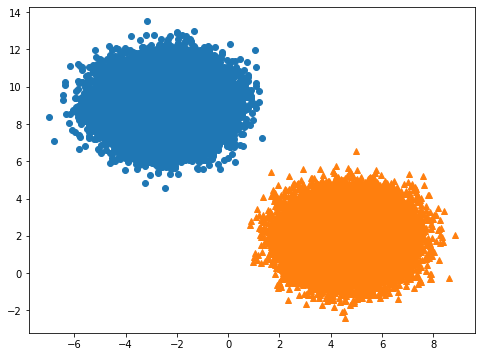

In [6]:
plot_data(X1, y1)

In [7]:
#slightly harder to separate
X2, y2 = make_moons(n_samples = samp, noise = 0.75, random_state = 42)
X2 = add_ones(X2)

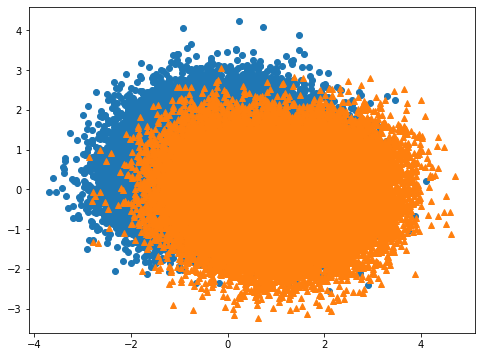

In [8]:
plot_data(X2, y2)

In [9]:
#extreme hard case
X3, y3 = make_gaussian_quantiles(n_samples = samp, n_features=2, n_classes=2, random_state = 42)
X3 = add_ones(X3)

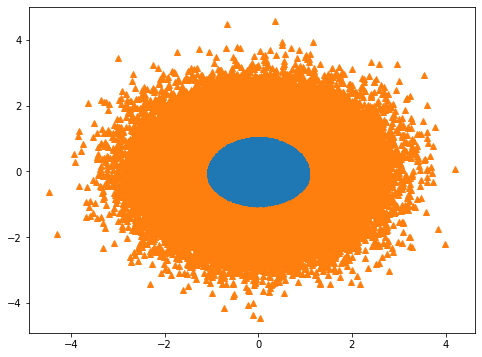

In [10]:
plot_data(X3, y3)

## Algorithm

In [11]:
def sigmoid(z):
    return 1.0/(1 + jnp.exp(-z))

In [12]:
def loss(w, X, y):
    margin = jnp.dot(X, w)
    l_if_pos = -jnp.logaddexp(0, -margin) * y
    l_if_neg = -jnp.logaddexp(0, margin) * (1 - y)
    
    l = -(l_if_pos + l_if_neg)
    
    return jnp.sum(l)

In [13]:
def train(X, y):
    # Initializing weights to zero.
    w = np.zeros(X.shape[1])

    # Find gradient and hessian
    loss_to_jit = partial(loss, X=X, y=y)
    jit_loss = jit(loss_to_jit)
    jit_loss_grad = jit(grad(loss_to_jit))
    jit_loss_hess = jit(hessian(loss_to_jit))
    
    # Train
    opt_w = scipy.optimize.fmin_ncg(jit_loss, x0=w, fprime=jit_loss_grad, fhess=jit_loss_hess)

    return opt_w

In [14]:
def predict(X, w, threshold=0.5):
    # Calculating presictions/y_hat.
    preds = sigmoid(jnp.dot(X, w))
    # Classify as 1 if prediction is above or equal to threshold
    pred_class = (preds >= threshold).astype(int)
    
    return pred_class

In [15]:
def accuracy(y, y_hat):
    accuracy = jnp.sum(y == y_hat) / len(y)
    return accuracy

In [16]:
def compare(X, y):
    # Training 
    start1 = time.time()
    w = train(X, y)
    pred = predict(X, w)
    acc = accuracy(y, pred)
    end1 = time.time()
    print(f'Time to run our logistic regression: {end1 - start1} s')
    print(f'Accuracy of our logistic regression: {acc}')
    
    
    start2 = time.time()
    lr = LogisticRegression()
    lr.fit(X, y)
    sk_acc = lr.score(X, y)
    end2 = time.time()
    print(f'Time to run Sklearn implementation {end2 - start2} s')
    print(f'Accuracy of Sklearn implementation: {sk_acc}')
    
    print(f'\nDifference in accuracies: {np.abs(acc-sk_acc)}')
    
    return w

In [17]:
def plot_line(X, y, w):
    m = -w[1]/w[2]
    b = w[0]
    c = -b/w[2]
    
    x1 = np.array([min(X[:,1]), max(X[:,1])])
    x2 = m*x1 + c
    
    # Plotting
    fig = plt.figure(figsize=(10,8))
    plt.plot(X[:, 1][y==0], X[:, 2][y==0], "g^")
    plt.plot(X[:, 1][y==1], X[:, 2][y==1], "bs")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title('Decision Boundary')
    plt.plot(x1, x2, 'y-')

#### Time results

In [18]:
X1, y1 = jnp.array(X1), jnp.array(y1)

In [19]:
w1 = compare(X1, y1)

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 27
         Function evaluations: 27
         Gradient evaluations: 27
         Hessian evaluations: 27
Time to run our logistic regression: 0.9697377681732178 s
Accuracy of our logistic regression: 1.0
Time to run Sklearn implementation 0.22525763511657715 s
Accuracy of Sklearn implementation: 1.0

Difference in accuracies: 0.0


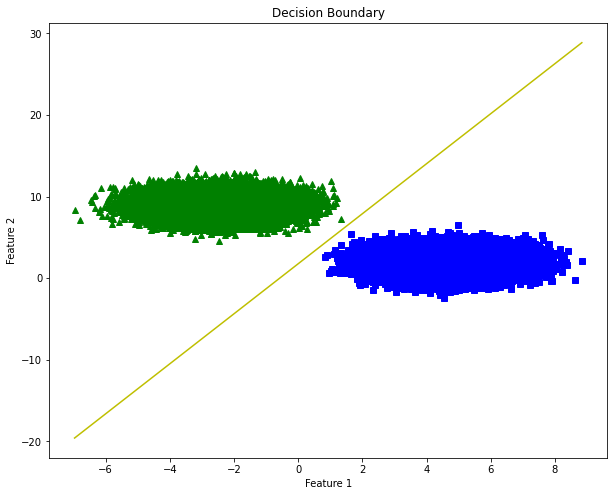

In [20]:
plot_line(X1, y1, w1)

In [21]:
X2, y2 = jnp.array(X2), jnp.array(y2)

In [22]:
w2 = compare(X2, y2)

         Current function value: 50571.472656
         Iterations: 7
         Function evaluations: 73
         Gradient evaluations: 61
         Hessian evaluations: 8
Time to run our logistic regression: 0.6977715492248535 s
Accuracy of our logistic regression: 0.7536799907684326
Time to run Sklearn implementation 0.0754704475402832 s
Accuracy of Sklearn implementation: 0.75368

Difference in accuracies: 0.0


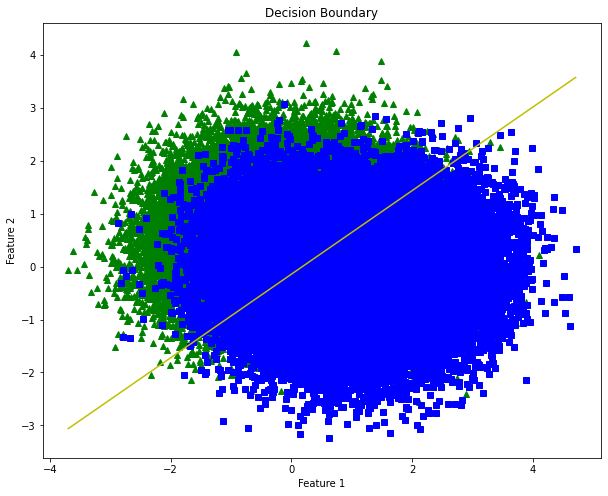

In [23]:
plot_line(X2, y2, w2)

In [24]:
X3, y3 = jnp.array(X3), jnp.array(y3)

In [25]:
w3 = compare(X3, y3)

         Current function value: 69312.359375
         Iterations: 2
         Function evaluations: 115
         Gradient evaluations: 101
         Hessian evaluations: 3
Time to run our logistic regression: 0.8403089046478271 s
Accuracy of our logistic regression: 0.5023900270462036
Time to run Sklearn implementation 0.04979991912841797 s
Accuracy of Sklearn implementation: 0.50225

Difference in accuracies: 0.00014001131057739258


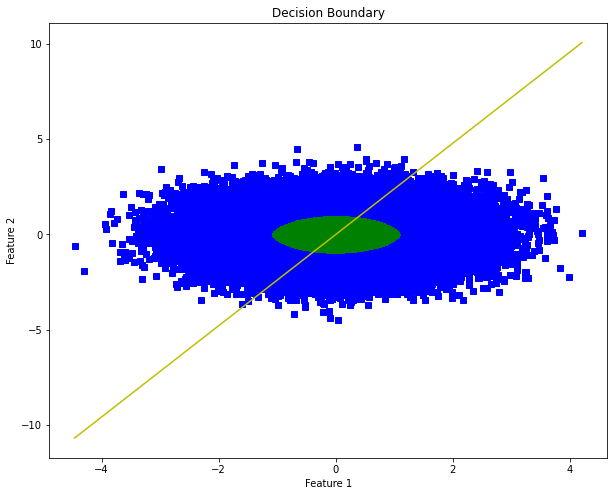

In [26]:
plot_line(X3, y3, w3)